<a href="https://colab.research.google.com/github/aranpandey/CornyWebbedRegisters/blob/master/Temp%2BMortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [586]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
import DLYHandler
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import datetime
from DLYHandler import read_ghcn_data_file

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [587]:
import pandas as pd
def readfileName(fileName, stateCode):
  colspecs = [(0, 10), (11, 17), (18, 24), (25, 31), (32, 38), (39, 45), (46,52), (53,59), (60,66), (67,73), (74,80), (81,87), (88,94)]
  colnames = ['metainfo', '01', '02', '03','04','05','06','07','08','09','10','11','12']
  df = pd.read_fwf(fileName, colspecs=colspecs, names=colnames, converters = {'metainfo':lambda x : str(x)})
  df['stateCode'] = df['metainfo'].str[:3]
  df['Year'] = df['metainfo'].str[6:10]
  df = df[(df['stateCode'] == '110')]

  return df

In [588]:
#TBD Reassess this method to see if we only take upper bound for TMX and lower bound fro TMIN. Yes choosing to do this now
def classifyIfInRange(row):
    #if row['TMAX'] < row['ci_low']:
     #   return 1
    #elif row['TMAX'] >row['ci_high']:
    if row['tmax'] >row['ci_high']:
        return 1
    else:
     return 0


def mean_confidence_interval(df_small, confidence=0.95):
    m=df_small['tmax'].mean()

    se=st.sem(df_small['tmax'] )
    
    h=st.norm.interval(0.95,m,se)
    
    return m, h

#This function calculates the mean and confidence interval for each week of the year. That is for 52 weeks.
#Need to do this for each year. TBD- adust the function to do for each year.
def populate_weekly_confidence(base_data,all_data):
    #loop through each record to find mean confidence interval for each row
    for i in range(1, 53):
       df_week= base_data [(base_data['Week'] ==i)] 
       upper_alt=mean_confidence_interval(df_week)    
       all_data.loc[all_data['Week'] == i, 'ci_low'] = upper_alt[1][0]
       all_data.loc[all_data['Week'] == i, 'ci_high'] = upper_alt[1][1]
    
def populate_monthly_confidence(base_data,all_data):
    for i in range(1, 13):
       df_month= base_data [(base_data['month'] ==i)] 
       upper_alt=mean_confidence_interval(df_month)    
       all_data.loc[all_data['month'] == i, 'ci_low'] = upper_alt[1][0]
       all_data.loc[all_data['month'] == i, 'ci_high'] = upper_alt[1][1]
    
    

In [589]:
df = readfileName('https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmaxst-v1.0.0-20230406', '110')
df.head()
df = df.melt(['metainfo','stateCode','Year'],var_name = 'month', value_name = 'tmax')
df['month'] = df['month'].astype(int)
df['Year'] = df['Year'].astype(int)
df.head()

,metainfo,stateCode,Year,month,tmax
0,1100271895,110,1895,1,36.86
1,1100271896,110,1896,1,41.41
2,1100271897,110,1897,1,37.65
3,1100271898,110,1898,1,40.77
4,1100271899,110,1899,1,39.88


In [590]:
base_data = df[(df['Year'] <= 1999)]
base_data.tail()

df.head()

,metainfo,stateCode,Year,month,tmax
0,1100271895,110,1895,1,36.86
1,1100271896,110,1896,1,41.41
2,1100271897,110,1897,1,37.65
3,1100271898,110,1898,1,40.77
4,1100271899,110,1899,1,39.88


In [591]:

populate_monthly_confidence(base_data,df)

df["EHE"] = df.apply(lambda row: classifyIfInRange(row), axis=1)
df.head()

,metainfo,stateCode,Year,month,tmax,ci_low,ci_high,EHE
0,1100271895,110,1895,1,36.86,39.837724,41.028943,0
1,1100271896,110,1896,1,41.41,39.837724,41.028943,1
2,1100271897,110,1897,1,37.65,39.837724,41.028943,0
3,1100271898,110,1898,1,40.77,39.837724,41.028943,0
4,1100271899,110,1899,1,39.88,39.837724,41.028943,0


In [592]:
df_w = df.groupby('Year')['EHE'].sum().reset_index()
df_w2 = df.groupby('Year')['tmax'].mean().reset_index()
df_w.head()
df_w = pd.merge(df_w, df_w2, on = 'Year')



In [593]:
df_mor = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Deaths_1x1.csv')

df_mor.head()

df_mor.dtypes
df_mor.columns = df_mor.columns.str.replace(' ', '')
df_mor_year = df_mor.groupby(['Year'])['Total'].sum().reset_index()
print(df_mor['Year'].agg(['min', 'max']))

df_mor_year.tail(500)
len(df_mor)
df_mor.head(1000)
df_mor['Year'] = df_mor['Year'].str.strip()
df_mor['Year'] = df_mor['Year'].str[:4]
df_mor_year = df_mor.groupby(['Year'])['Total'].sum().reset_index()

df_mor_year.head(1000)

min      1933         1
max                2021
Name: Year, dtype: object


,Year,Total
0,1933,1342105.95
1,1934,1396903.06
2,1935,1392751.95
3,1936,1479228.21
4,1937,1450426.97
5,1938,1381391.04
6,1939,1387897.03
7,1940,1417269.06
8,1941,1397641.93
9,1942,1385187.11


In [594]:
df.dtypes
df_mor_year['Year'] = df_mor_year['Year'].astype('int64')

df['Year'] = df['Year'].astype('int64')
df_w.astype('int64')
df_merged= pd.merge(df_mor_year, df_w, on="Year", how = 'left').reset_index() 
df_merged.head(10)


,index,Year,Total,EHE,tmax
0,0,1933,1342105.95,7,65.407500
1,1,1934,1396903.06,10,66.762500
2,2,1935,1392751.95,6,63.676667
3,3,1936,1479228.21,7,64.602500
4,4,1937,1450426.97,4,63.439167
5,5,1938,1381391.04,8,65.215833
6,6,1939,1387897.03,10,65.905833
7,7,1940,1417269.06,6,63.732500
8,8,1941,1397641.93,5,64.084167
9,9,1942,1385187.11,4,63.845000


In [595]:
inputs = df_merged['EHE'].to_numpy()             
outputs = df_merged['Total'].to_numpy()
df.tail(5)
days = []
count = 0
for elements in inputs:
  count += 1
  days.append(count)
df_merged['elapsed'] = days
df_merged.head()

,index,Year,Total,EHE,tmax,elapsed
0,0,1933,1342105.95,7,65.407500,1
1,1,1934,1396903.06,10,66.762500,2
2,2,1935,1392751.95,6,63.676667,3
3,3,1936,1479228.21,7,64.602500,4
4,4,1937,1450426.97,4,63.439167,5


In [596]:
past = 5
s = (len(inputs) , past  * 2)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))

for i in range(len(inputs) - past): # - 0
  temp = np.zeros(past * 2)
  temp[0 : past] = inputs[i : i+ past]
  temp[past:] = outputs[i : i + past] 
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

In [597]:
betterinputs = betterinputs[0:len(df) - past] # - 0
betteroutputs = betteroutputs[0:len(df) - past]
days = days[0:len(df) - past]

In [598]:
from matplotlib import pyplot as plt
split = int(0.8*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)  
X_test = np.expand_dims(X_test, axis=2) 
days = days[split:]


1.7418700331501629


array([-3.59434854, -4.12081148])

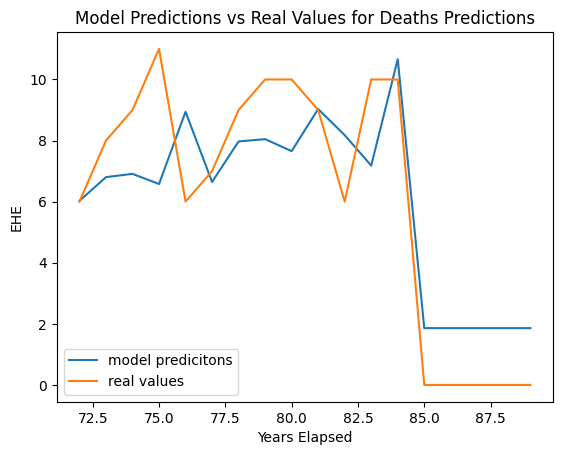

In [599]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
model = RidgeCV(cv = 2)
#model = LinearRegression()
#model = GradientBoostingRegressor()

X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
model.fit(X_train, y_train)
print("{}".format(np.linalg.norm(model.predict(X_test) - y_test, 1)/len(y_test)))
predict = model.predict(X_test)
plt.title("Model Predictions vs Real Values for Deaths Predictions")
plt.ticklabel_format(style='plain')
plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()
cross_val_score(model, X_train, y_train, cv = 2)


In [600]:
from sklearn.metrics import mean_squared_error
print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

0.7506071951730298
4.163474325028031
2.040459341674818
